In [2]:
colab = False
if colab:
    !pip install datasets langdetect
    !git clone https://github.com/reddgr/chatbot-response-scoring-scbn-rqtl
    import os
    os.system("mv chatbot-response-scoring-scbn-rqtl scbn_rqtl")

In [23]:
use_dotenv = True # Set to True if you use a .env file to store your HuggingFace token(s). Set to False if you use environment variables.

import sys
import os
import torch
from torch.utils.data import DataLoader
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from transformers import pipeline, TrainerCallback, AdamW, TFAutoModelForSequenceClassification
from datasets import Dataset, load_dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import textwrap
from IPython.display import clear_output
import random
from ipywidgets import Button, HBox, VBox, Output

if colab:
  from scbn_rqtl import text_classification_functions as tcf
  from scbn_rqtl import labeling_widget
else:
  import text_classification_functions as tcf
  import labeling_widget

# Checking versions and GPU availability:
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
else:
    print("No CUDA device available")

# Checks HuggingFace token
if use_dotenv:
    print("Using .env file to store HuggingFace token(s)")
    from dotenv import load_dotenv
    load_dotenv("C:/apis/.env") # path to your dotenv file
    hf_token = os.getenv("HF_TOKEN")
    hf_token_write = os.getenv("HF_TOKEN_WRITE") # Only used for updating the Reddgr dataset (privileges needed)
elif colab:
    from google.colab import userdata
    hf_token = userdata.get('HF_TOKEN')
    hf_token_write = userdata.get('HF_TOKEN_WRITE')
else:
    print("Using environment variables to store HuggingFace token(s)")
    hf_token = os.environ.get("HF_TOKEN")
    hf_token_write = os.environ.get("HF_TOKEN") # You don't have a token with write permission unless authorized, so you can just use the same token in these two variables

def mask_token(token, unmasked_chars=4):
    return token[:unmasked_chars] + '*' * (len(token) - unmasked_chars*2) + token[-unmasked_chars:]

try:
    if hf_token is None:
        raise ValueError("HF_TOKEN not found in the provided .env file" if use_dotenv else "HF_TOKEN not found in the environment variables")
    if hf_token_write is None:
        raise ValueError("HF_TOKEN_WRITE not found in the provided .env file" if use_dotenv else "HF_TOKEN_WRITE not found in the environment variables")

    masked_hf_token = mask_token(hf_token)
    masked_hf_token_write = mask_token(hf_token_write)

    print(f"Using HuggingFace token: {masked_hf_token}")
    print(f"Using HuggingFace write token: {masked_hf_token_write}")
except ValueError as e:
    print(e)

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
PyTorch version: 2.2.2
Transformers version: 4.44.2
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Using .env file to store HuggingFace token(s)
Using HuggingFace token: hf_B*****************************PHte
Using HuggingFace write token: hf_E*****************************hyNP


In [ ]:
### DEBUG ###
import importlib
importlib.reload(labeling_widget)
importlib.reload(tcf)
### DEBUG ###

<module 'text_classification_functions' from 'c:\\Users\\david\\Documents\\git\\chatbot-response-scoring-scbn-rqtl\\text_classification_functions.py'>

# TL model

### Testing current model

Loading Test split from dataset:

In [4]:
test_dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
test_dataset = test_dataset_dict["test"]  # Access the "test" split
test_dataset_df = test_dataset_dict["test"].to_pandas()
display(test_dataset_df.head(3))
print('...')
display(test_dataset_df.tail(3))

Generating train split:   0%|          | 0/239 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/176 [00:00<?, ? examples/s]

,text,label
0,How Many Rs are there in strawberry?,1
1,How do I sort an array in python?,0
2,What is your latest version of Apache Pulsar,0


...


,text,label
173,This is a question someone I trust inspired me...,1
174,How would you briefly describe Peter Seller’s ...,1
175,Make a list of companies which are comparable ...,0


Main testing metrics. The model is considered OK for most purposes if accuracy > 0.8 and cross entropy loss >0.2 and < 0.5 (it is desirable that the cross entropy loss is not too low, even for the test data examples, as there's utility in the output of the classifier being a probability and not strictly 0 or 1)

Classifying: 100%|██████████| 176/176 [00:14<00:00, 12.15it/s]

Accuracy: 0.8295
F1 Score: 0.8325
Cross Entropy Loss: 0.4046


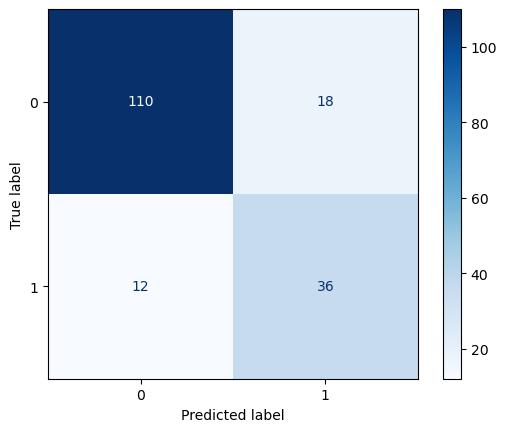

In [5]:
tl_model_path = "reddgr/tl-test-learn-prompt-classifier"
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.Classifier(tl_model_path, tl_label_map)
clear_output(wait=True)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

Show prediction examples:

In [6]:
tl_classifier = tcf.Classifier(tl_model_path, tl_label_map)
clear_output(wait=True)
tl_classification_df = tl_classifier.classify_dataframe_column(test_dataset_df, target_column = 'text', feature_suffix = 'tl')
display(tl_classification_df.sample(5))

Classifying: 100%|██████████| 176/176 [00:15<00:00, 11.33it/s]


,text,label,pred_label_tl,prob_tl
56,include suggested hostels based on popularity,0,learn,0.959359
14,can you please convert this table to SQL?,0,learn,0.958985
155,how do I add space between the text lines and ...,0,learn,0.954823
102,what is the most likely cause of the current i...,0,learn,0.759150
131,"which one is more correct, ""went public at the...",0,test,0.937232


### Fine-tuning the model

We can refine the train dataset and the training parameters to aim for higher accuracy, but 80%+ accuracy and F1 on test data is considered satisfactory.

Load train dataset:

In [7]:
dataset_dict = load_dataset("reddgr/tl-test-learn-prompts")
dataset = dataset_dict["train"]  # Access the "train" split
print(dataset)
display(dataset.to_pandas().head(5))
print('...')
display(dataset.to_pandas().tail(5))

Dataset({
    features: ['text', 'label'],
    num_rows: 239
})


,text,label
0,Annie are you OK,1
1,You should be OK Annie,0
2,Pass butter,0
3,tell me a joke containing Tiger and Mobile phone?,0
4,How to initialize the classification head when...,0


...


,text,label
234,"fix this ""it was well paid, but not that well ...",0
235,"fix this ""Yeah, I took the job due to a referr...",0
236,"Hi, I work as a data analyst for telecom compa...",0
237,start explaining probability theory,0
238,Is it possible to write a powershell script wh...,0


### Training with Tensorflow backend

Epoch 1/6


21/21 [==============================] - 70s 3s/step - loss: 0.6874 - accuracy: 0.5509 - val_loss: 0.6673 - val_accuracy: 0.5972
Epoch 2/6
21/21 [==============================] - 59s 3s/step - loss: 0.6424 - accuracy: 0.7725 - val_loss: 0.6094 - val_accuracy: 0.8194
Epoch 3/6
21/21 [==============================] - 59s 3s/step - loss: 0.5270 - accuracy: 0.8623 - val_loss: 0.4773 - val_accuracy: 0.9028
Epoch 4/6
21/21 [==============================] - 59s 3s/step - loss: 0.3559 - accuracy: 0.9222 - val_loss: 0.3937 - val_accuracy: 0.8611
Epoch 5/6
21/21 [==============================] - 59s 3s/step - loss: 0.2055 - accuracy: 0.9581 - val_loss: 0.2708 - val_accuracy: 0.9167
Epoch 6/6
21/21 [==============================] - 61s 3s/step - loss: 0.0996 - accuracy: 1.0000 - val_loss: 0.3961 - val_accuracy: 0.8194


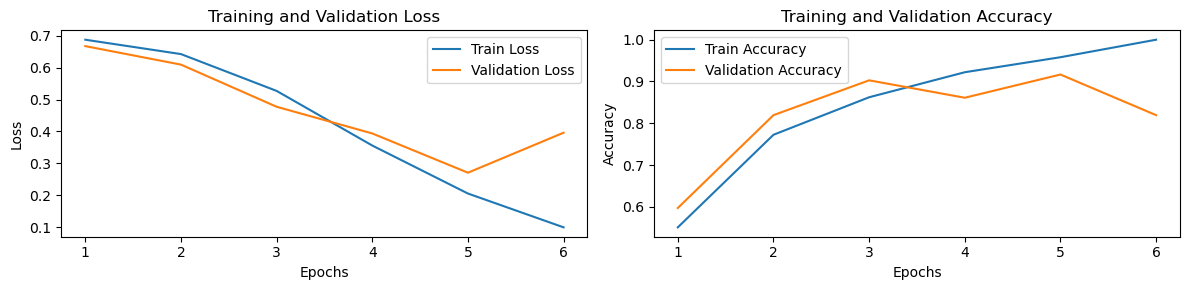

In [8]:
# Main parameters:
learning_rate=0.00001
n_epochs=6

# Split data into train and test sets using `datasets` library
dataset_split = dataset.train_test_split(test_size=0.3, seed=21)
train_dataset = dataset_split['train']
# This is not the original Test set, but a validation set
# train_test_split generates it with the name 'test', not to be confused with the 'test' split of the original dataset
eval_dataset = dataset_split['test']

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

def tokenize_function(examples, tokenizer=tokenizer):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# tokenized_dataset = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Convert tokenized datasets to TensorFlow datasets
train_tf_dataset = tokenized_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=8
)

eval_tf_dataset = tokenized_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=8
)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

clear_output(wait=True) # remove library warnings
history = model.fit(
    train_tf_dataset,
    validation_data=eval_tf_dataset,
    epochs=n_epochs
)

# Plot training and validation losses and accuracies in a 1x2 grid
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
epochs = range(1, len(history.history['loss']) + 1)

# Plot losses
axes[0].plot(epochs, history.history['loss'], label='Train Loss')
axes[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot accuracies
axes[1].plot(epochs, history.history['accuracy'], label='Train Accuracy')
axes[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

Saving the model locally before testing:

In [9]:
model.save_pretrained("fine-tuned-distilbert-tl-testing")
tokenizer.save_pretrained("fine-tuned-distilbert-tl-testing")

('fine-tuned-distilbert-tl-testing\\tokenizer_config.json',
 'fine-tuned-distilbert-tl-testing\\special_tokens_map.json',
 'fine-tuned-distilbert-tl-testing\\vocab.txt',
 'fine-tuned-distilbert-tl-testing\\added_tokens.json',
 'fine-tuned-distilbert-tl-testing\\tokenizer.json')

### Evaluating the model with Test dataset:

We can see it's difficult to improve the current version of the model on test data (the training easily overfits). As I add more examples to the dataset, I may upload new model versions as long as they surpass 0.85 accuracy and get below 0.4 cross entropy loss on test data (0.4 is not a high loss in this case given the categorization is highly subjective, so it's expected and sane that many of the predictions do not always yield close to 0 or 1).

Some layers from the model checkpoint at fine-tuned-distilbert-tl-testing were not used when initializing TFDistilBertForSequenceClassification: ['dropout_59']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at fine-tuned-distilbert-tl-testing and are newly initialized: ['dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fallback to HuggingFace pipeline.


Classifying: 100%|██████████| 176/176 [00:15<00:00, 11.56it/s]

Accuracy: 0.8523
F1 Score: 0.8401
Cross Entropy Loss: 0.4379


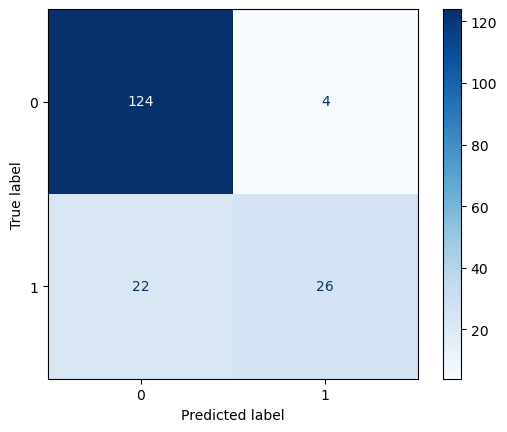

In [10]:
# tl_model_path = "fine-tuned-distilbert-tl-testing" # Path to the local folder where the model and tokenizer are saved
tl_label_map = {0: "learn", 1: "test"}
tl_test_classifier = tcf.TensorflowClassifier(model_path="fine-tuned-distilbert-tl-testing", label_map=tl_label_map, verbose = True)
tl_test_metrics = tl_test_classifier.test_model_predictions(test_dataset_df, target_column = 'text')

### Testing with unlabeled data

#### Extracting LMSYS examples:

In [ ]:
if colab:
  streaming = True
else: 
  streaming = False

lmsys_dataset = load_dataset(
  'lmsys/lmsys-chat-1m',
  revision="main",
  token=hf_token,
  streaming=streaming
)
print(lmsys_dataset)

if not streaming:
  print('Data is cached at:\n')
  for file_info in lmsys_dataset['train'].cache_files:
      filename = file_info['filename']
      file_size = os.path.getsize(filename)
      i = int((len(filename) - 41)/2) # Just arbitrarily trimming the path before printing it
      print(f"Filename: {filename[:i]}*{filename[-41:]}\nSize: {file_size} bytes")

DatasetDict({
    train: Dataset({
        features: ['conversation_id', 'model', 'conversation', 'turn', 'language', 'openai_moderation', 'redacted'],
        num_rows: 1000000
    })
})
Data is cached at:

Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00000-of-00006.arrow
Size: 501562824 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00001-of-00006.arrow
Size: 499323288 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00002-of-00006.arrow
Size: 501365960 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00003-of-00006.arrow
Size: 499767784 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00004-of-00006.arrow
Size: 499761448 bytes
Filename: C:\Users\david\.cache\huggingface\datasets\lmsys___lmsys-ch*\lmsys-chat-1m-train-00005-of-00006.arrow
Size: 1266

In [ ]:
if not streaming:
  n_samples = 500
  df_sample = lmsys_dataset['train'].to_pandas().sample(n_samples)
  print(f"Retrieved {n_samples} samples")
  display(df_sample.head(2))
  print('...')
  display(df_sample.tail(2))

if streaming:
  # Take a sample from the streamed dataset
  n_samples = 10000
  streamed_samples = []
  for i, row in enumerate(lmsys_dataset['train']):
      streamed_samples.append(row)
      if i + 1 == n_samples:  # Collect only the desired number of samples
          break

  # Shuffle and convert the collected samples to a Pandas DataFrame
  random.shuffle(streamed_samples)
  df_sample = pd.DataFrame(streamed_samples)
  print(f"Retrieved {n_samples} samples")
  display(df_sample.head(2))
  print('...')
  display(df_sample.tail(2))

Retrieved 500 samples


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
770256,dcc3ccbfa29c47e7bf4a1b5dfa2da2c9,mpt-30b-chat,"[{'content': 'Does the pope fly?', 'role': 'us...",1,English,"[{'categories': {'harassment': False, 'harassm...",False
442139,a4537e6183714190ae5949ab188c5a33,vicuna-13b,[{'content': 'generate code for simple calcula...,1,English,"[{'categories': {'harassment': False, 'harassm...",False


...


,conversation_id,model,conversation,turn,language,openai_moderation,redacted
688265,4b27703f90d64fa6815b7e74fc97835c,koala-13b,[{'content': 'How to get a colleague to advoca...,1,English,"[{'categories': {'harassment': False, 'harassm...",True
722597,1b5262a522684ad4a43022e735199559,dolly-v2-12b,[{'content': 'Which country discovered Austral...,2,English,"[{'categories': {'harassment': False, 'harassm...",True


In [15]:
filter_language = 'English'
max_char_length = 400 # we limit the number of characters so we get specifically messages that are quick to label and validate manually
# Flatten the array and extract 'content' where 'role' == 'user' and language matches the filter
extracted_data = df_sample[df_sample['language'] == filter_language].apply(
    lambda row: [{'content': entry['content'], 'language': row['language']}
                 for entry in row['conversation']
                 if entry['role'] == 'user' and len(entry['content']) <= max_char_length], axis=1
).explode().dropna()

# Create a new DataFrame from the extracted data
df_extracted = pd.DataFrame(extracted_data.tolist())
display(df_extracted)

,content,language
0,Does the pope fly?,English
1,generate code for simple calculator in cpp,English
2,What is audio?,English
3,What is 9D audio?,English
4,what is a woman?,English
...,...,...
546,Create 10 questions and only return them in a ...,English
547,make mardown editor app for android and linux,English
548,How to get a colleague to advocate for their o...,English
549,Which country discovered Australia (in modern ...,English


Classify random prompts:

In [16]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

# Get the model's maximum sequence length
max_seq_length = model.config.max_position_embeddings

# Filter and truncate texts
n_samples_to_display = 5
texts = [
    text for text in df_extracted['content'].sample(n_samples_to_display).tolist()
    if len(tokenizer.encode(text, add_special_tokens=True)) <= max_seq_length
]

# Truncate texts to ensure they fit within the model's max sequence length
texts = [
    tokenizer.decode(
        tokenizer.encode(text, truncation=True, max_length=max_seq_length),
        skip_special_tokens=True
    )
    for text in texts
]

# Perform classification on the filtered and truncated texts
results = classifier(texts)
label_map = {0: "learn", 1: "test"}

# Display classification results
print("### Classification with fine-tuned distilbert-base-uncased ###\n")
for text, result in zip(texts, results):
    label_str = label_map[int(result['label'].split('_')[-1])]
    prob = result['score']
    wrapped_text = textwrap.fill(text, width=120)
    print(f"{label_str} ({prob:.3f})\n{wrapped_text}\n")

### Classification with fine-tuned distilbert-base-uncased ###

learn (0.561)
who are you?

learn (0.946)
could you integrate all of these descriptions into a coherent voice?

test (0.829)
what time does the sauna close

test (0.688)
chabrey is a former municipality in the district of broye - vully in the canton of vaud in switzerland. the
municipalities of bellerive, chabrey, constantine, montmagny, mur, vallamand and villars - le - grand merged on 1 july
2011 into the new municipality of vully - les - lacs. answer in one word, yes or no. is chabrey a place?

learn (0.963)
can you show me how to make the blink program on arduino?



### Manual labeling

See dataset-handling.ipynb

In [ ]:
tl_labeling_widget = labeling_widget.LabelingWidget()
# Start the manual labeling process
df_extracted.rename(columns={"content": "text"}, inplace=True)
tl_labeling_widget.manual_labeling(df_extracted, classifier, label_map)

Push new labeled texts to dataset:

In [24]:
tl_labeling_widget.update_dataset(
    dataset_name="reddgr/tl-test-learn-prompts",
    split_name="train", # Set whether you want to update the 'train' or 'test' split
    hf_token=hf_token_write
)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/2.90k [00:00<?, ?B/s]

c:\Users\david\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\david\.cache\huggingface\hub\datasets--reddgr--tl-test-learn-prompts. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Successfully pushed 14 records to reddgr/tl-test-learn-prompts train split.


### Push model to hub

In [39]:
model.push_to_hub("reddgr/tl-test-learn-prompt-classifier", token=hf_token_write)
tokenizer.push_to_hub("reddgr/tl-test-learn-prompt-classifier", token=hf_token_write)

tf_model.h5:   0%|          | 0.00/268M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.12k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reddgr/tl-test-learn-prompt-classifier/commit/2bbfc01fc025ef16971c09398925f710f1a94a24', commit_message='Upload tokenizer', commit_description='', oid='2bbfc01fc025ef16971c09398925f710f1a94a24', pr_url=None, repo_url=RepoUrl('https://huggingface.co/reddgr/tl-test-learn-prompt-classifier', endpoint='https://huggingface.co', repo_type='model', repo_id='reddgr/tl-test-learn-prompt-classifier'), pr_revision=None, pr_num=None)